# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

## Imports

In [73]:
# YOUR CODE HERE
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import helper_utils
import time
import copy



## Setup Device

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [1]:
# YOUR CODE HERE
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Path to dataset files: /kaggle/input/intel-image-classification


**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [33]:
# YOUR CODE HERE
train_dataset = datasets.ImageFolder(root ="/kaggle/input/intel-image-classification/seg_train/seg_train")
val_dataset = datasets.ImageFolder(root ="/kaggle/input/intel-image-classification/seg_test/seg_test")
class_names = train_dataset.classes

**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [34]:
# YOUR CODE HERE
print(len(train_dataset))
print(len(val_dataset))

14034
3000


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [77]:
# YOUR CODE HERE
#imgnet stats
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset.transform = train_transform
val_dataset.transform = val_transform


In [78]:
# YOUR CODE HERE
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {"train": train_loader, "val": val_loader}

**Quick Check**: Visualize a batch of training images

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
%cd "/content/drive/MyDrive/Bootcamp/project"

/content/drive/MyDrive/Bootcamp/project


In [28]:
helper_utils.visualize_batch?

<function helper_utils.visualize_batch(dataloader, class_names, num_images=8, figsize=(12, 6))>

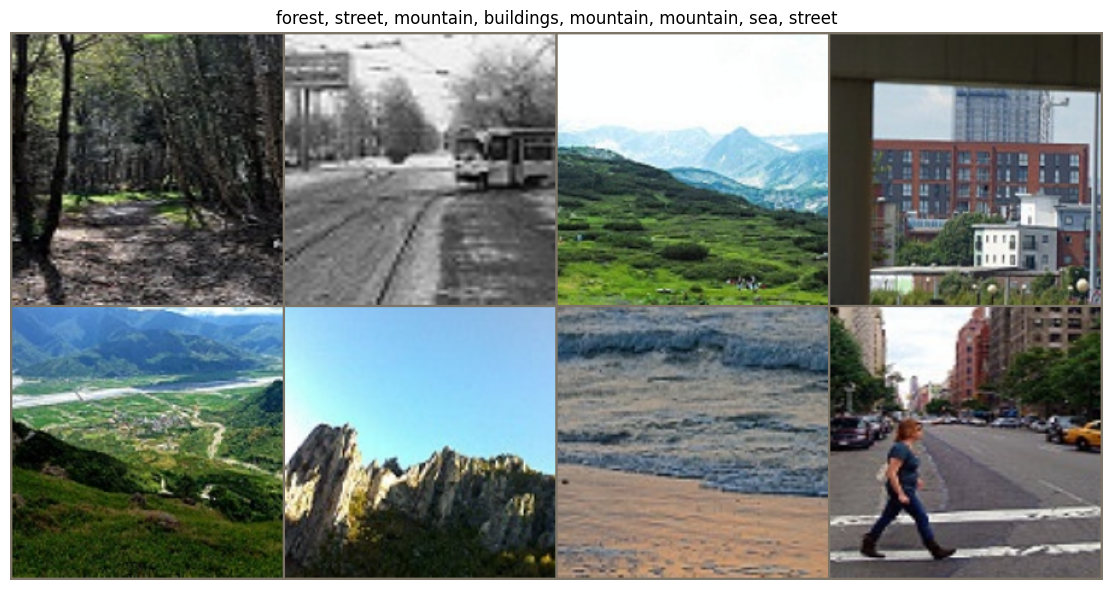

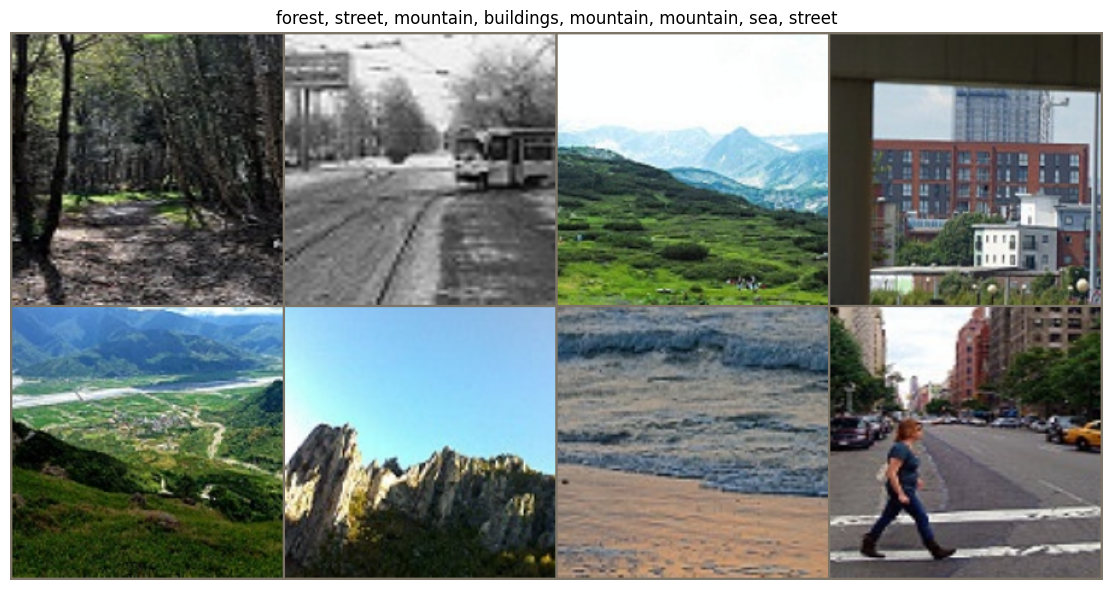

In [79]:
# YOUR CODE HERE
helper_utils.visualize_batch(train_loader,class_names)

<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [90]:
# YOUR CODE HERE
model_ft = models.resnet18(weights='DEFAULT')

<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [80]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)
        preds = logits.argmax(dim=1)

        running_loss += loss.item() * x.size(0)
        running_corrects += (preds == y).sum().item()
        total += x.size(0)

    return running_loss / total, running_corrects / total


def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=5):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    best_wts = copy.deepcopy(model.state_dict())
    best_val_acc = -1.0

    for epoch in range(num_epochs):
        # ---- Train ----
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for x, y in dataloaders["train"]:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            preds = logits.argmax(dim=1)

            running_loss += loss.item() * x.size(0)
            running_corrects += (preds == y).sum().item()
            total += x.size(0)

        train_loss = running_loss / total
        train_acc = running_corrects / total

        # ---- Val ----
        val_loss, val_acc = evaluate(model, dataloaders["val"], criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_wts = copy.deepcopy(model.state_dict())

        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
            f"val loss {val_loss:.4f} acc {val_acc:.4f}"
        )

    model.load_state_dict(best_wts)
    return model, history


<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [98]:
model_fe = model_ft
for param in model_fe.parameters():
    param.requires_grad = False
num_ftrs = model_fe.fc.in_features
model_fe.fc = nn.Linear(num_ftrs, 6)
model_fe = model_fe.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_fe = optim.SGD(model_fe.fc.parameters(), lr=1e-3, momentum=0.9)
model_fe, history_fe = train_model(
    model_fe,
    dataloaders,
    loss_fn,
    optimizer_fe,
    device,
    num_epochs=5
)

Epoch 1/5 | train loss 0.5430 acc 0.8088 | val loss 0.2679 acc 0.9090
Epoch 2/5 | train loss 0.3746 acc 0.8663 | val loss 0.2565 acc 0.9087
Epoch 3/5 | train loss 0.3731 acc 0.8645 | val loss 0.2446 acc 0.9093
Epoch 4/5 | train loss 0.3567 acc 0.8706 | val loss 0.2399 acc 0.9160
Epoch 5/5 | train loss 0.3490 acc 0.8730 | val loss 0.2345 acc 0.9170


In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

**Quick Check**: Visualize training history

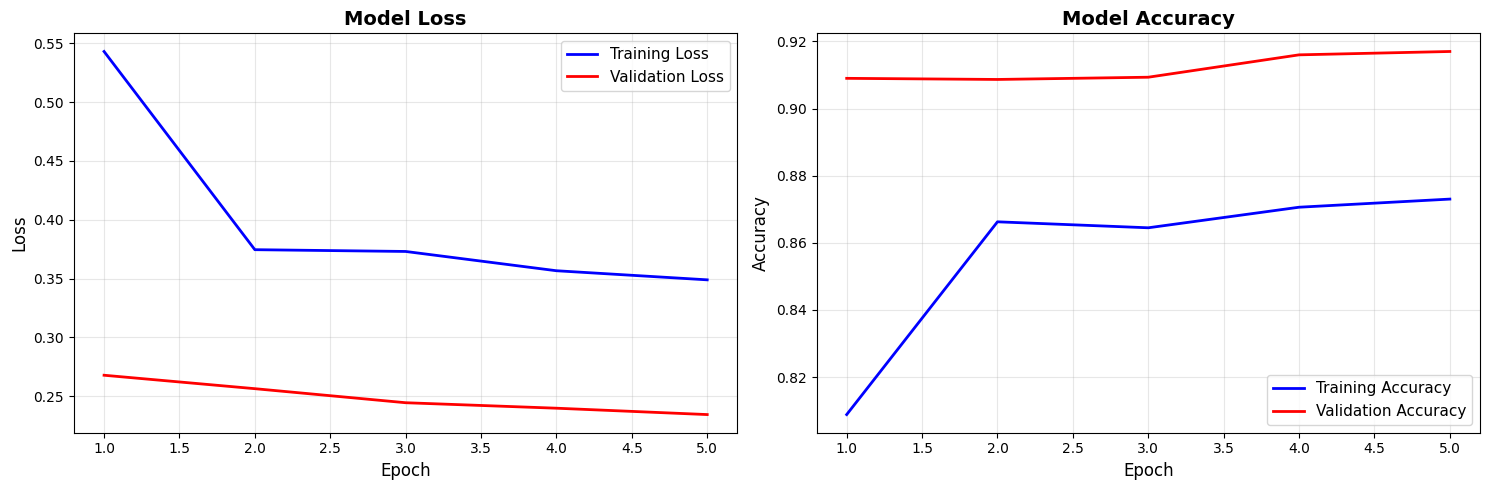

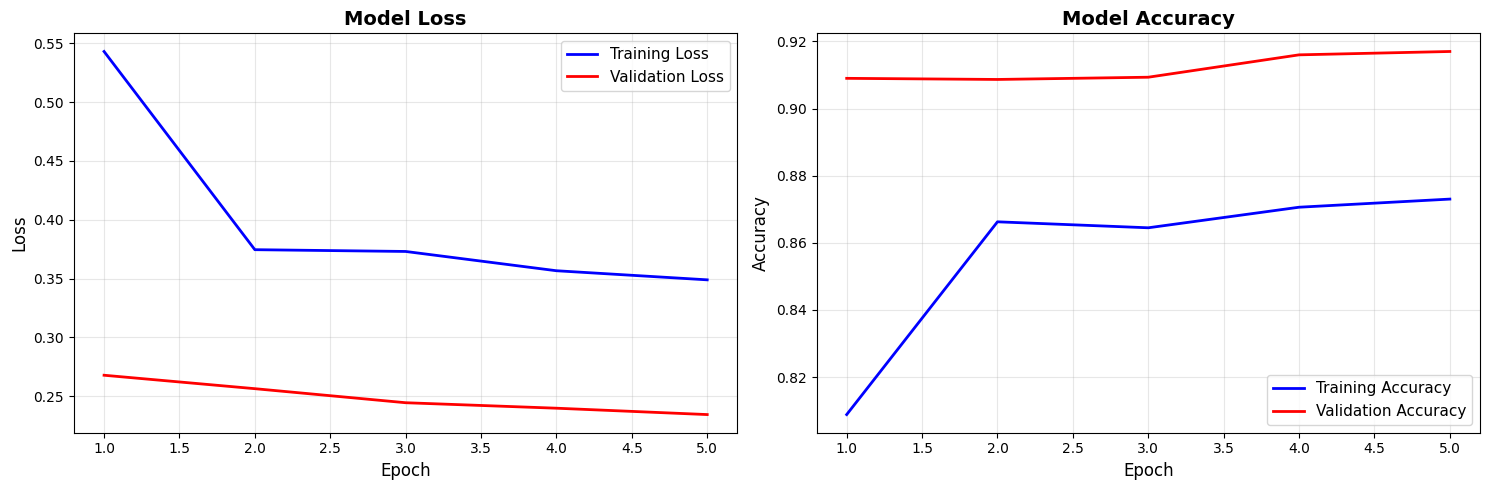

In [99]:
helper_utils.visualize_training_history(history_fe)


**Quick Check**: Visualize predictions

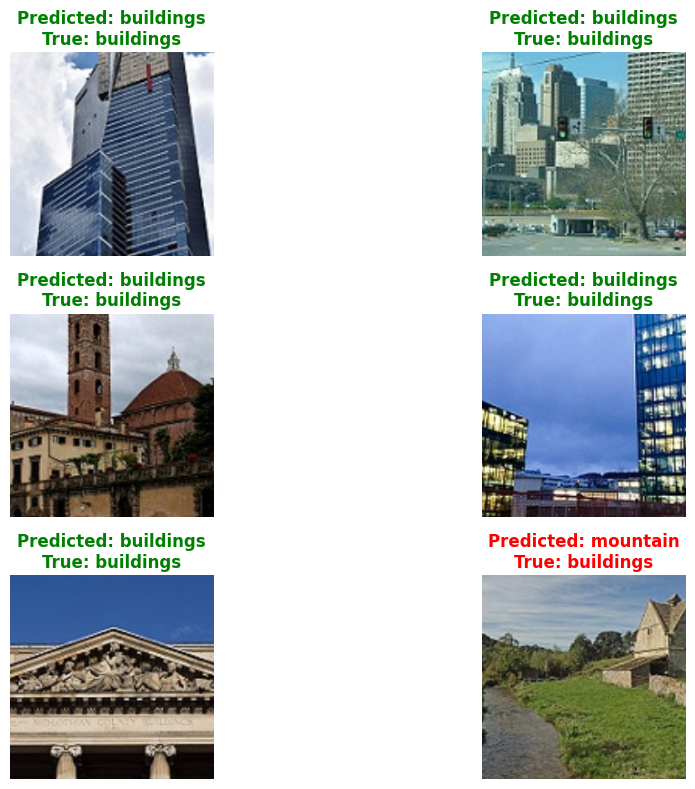

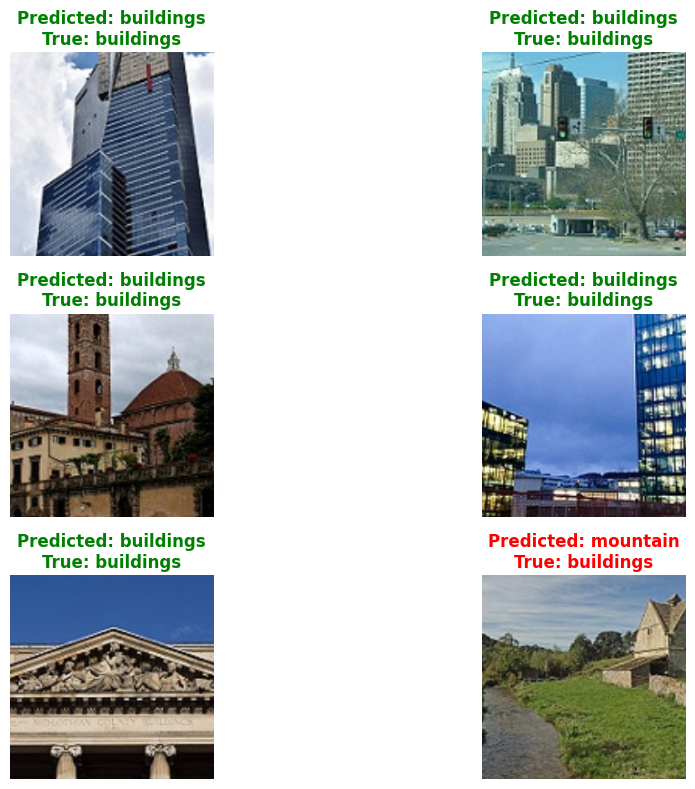

In [93]:
helper_utils.visualize_predictions(model_fe, dataloaders['val'], class_names, device, num_images=6)
# plt.show()

<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [94]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 6)
for param in model_ft.parameters():
    param.requires_grad = True
model_ft = model_ft.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-4, momentum=0.9)
history_ft = train_model(model_ft, dataloaders, loss_fn, optimizer_ft, device, num_epochs=5)

Epoch 1/5 | train loss 1.2169 acc 0.5968 | val loss 0.6528 acc 0.8340
Epoch 2/5 | train loss 0.6367 acc 0.8132 | val loss 0.4159 acc 0.8753
Epoch 3/5 | train loss 0.4966 acc 0.8413 | val loss 0.3359 acc 0.8967
Epoch 4/5 | train loss 0.4347 acc 0.8578 | val loss 0.2997 acc 0.9013
Epoch 5/5 | train loss 0.4042 acc 0.8638 | val loss 0.2748 acc 0.9040


In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

**Quick Check**: Visualize training history

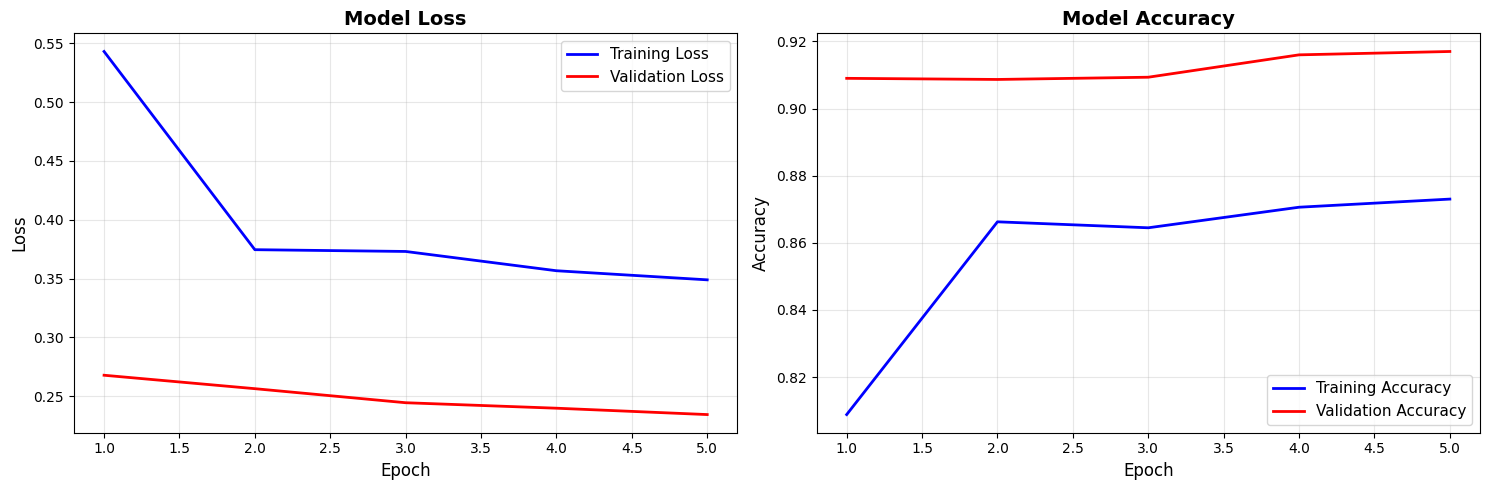

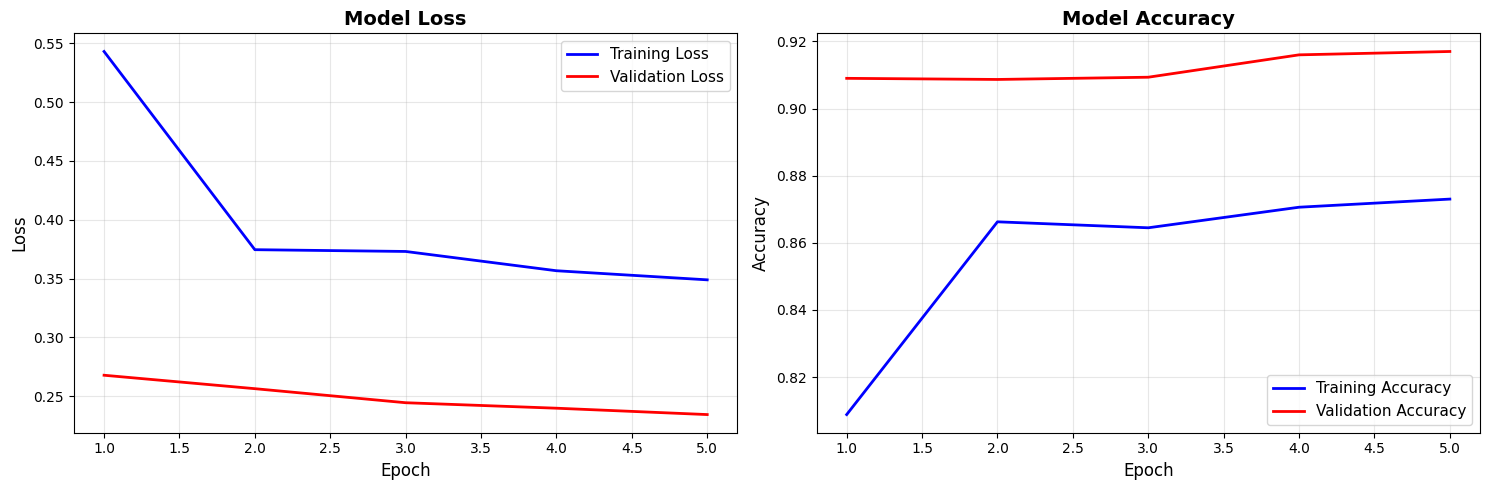

In [101]:
helper_utils.visualize_training_history(history_fe)
# plt.show()

**Quick Check**: Visualize predictions

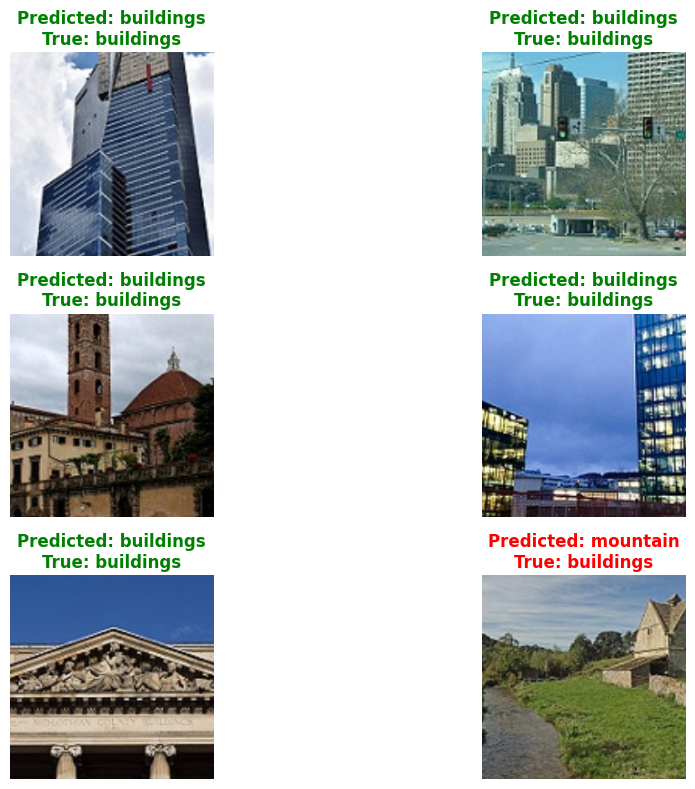

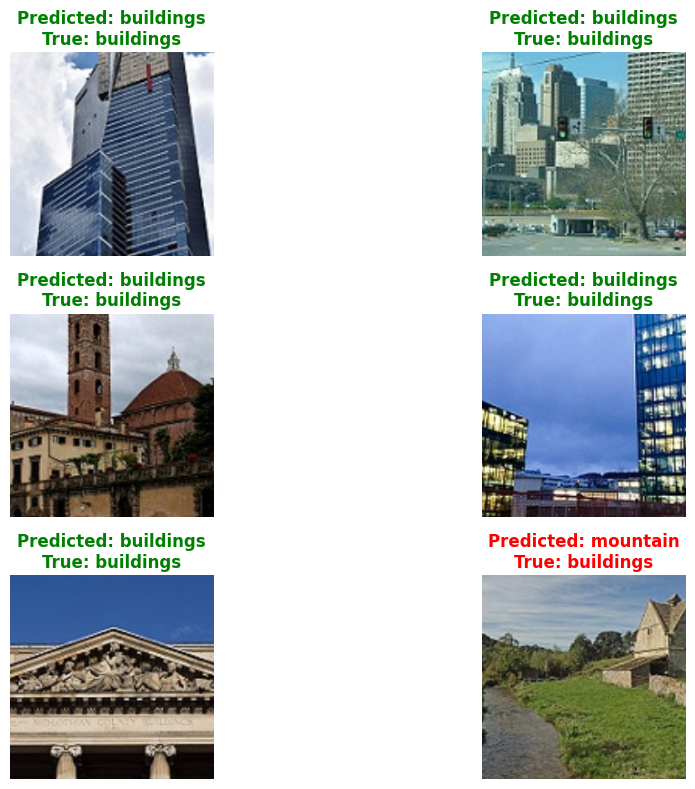

In [96]:
helper_utils.visualize_predictions(model_ft, dataloaders['val'], class_names, device, num_images=6)
# plt.show()

<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [102]:
# Evaluate models on validation set
# YOUR CODE HERE
# Compare final validation accuracies, training times, etc.

# Print comparison
print("Feature Extractor Approach:")
print(f"  Best Val Accuracy: {max(history_fe['val_acc']):.4f}")
print(f"  Final Val Accuracy: {history_fe['val_acc'][-1]:.4f}")
print()
print("Fine-tuning Approach:")
print(f"  Best Val Accuracy: {max(history_ft['val_acc']):.4f}")
print(f"  Final Val Accuracy: {history_ft['val_acc'][-1]:.4f}")

Feature Extractor Approach:
  Best Val Accuracy: 0.9170
  Final Val Accuracy: 0.9170

Fine-tuning Approach:


TypeError: tuple indices must be integers or slices, not str

<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

In [110]:

img_path ="/kaggle/input/intel-image-classification/seg_test/seg_test/forest/20056.jpg"
pred_class, conf = helper_utils.predict_single_image(
    model_ft,
    img_path,
    val_transform,
    class_names,
    device
)

print(f"Predicted: {pred_class}, Confidence: {conf:.2%}")



Predicted: forest, Confidence: 99.86%


# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [107]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.2 MB/s eta 0:00:00


In [106]:
# Convert model to ONNX
# YOUR CODE HERE


# Set model to evaluation mode
model_ft.eval()

# Create dummy input (batch_size=1, channels=3, height=224, width=224)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
onnx_path = 'model.onnx'
torch.onnx.export(
    model_ft,
    dummy_input,
    onnx_path,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"Model exported to {onnx_path}")

/tmp/ipython-input-4085544828.py:13: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 41 of general pattern rewrite rules.
Model exported to model.onnx


In [112]:
# Load ONNX model and perform inference
# YOUR CODE HERE
import numpy as np
import onnxruntime as ort
from PIL import Image

# Load ONNX model
ort_session = ort.InferenceSession(onnx_path)



img = Image.open(img_path).convert('RGB')
img_tensor = val_transform(img).unsqueeze(0)
img_numpy = img_tensor.numpy()

# Run inference
outputs = ort_session.run(None, {'input': img_numpy})
predictions = np.array(outputs[0])
pred_class_idx = np.argmax(predictions[0])
pred_class = class_names[pred_class_idx]
confidence = np.max(predictions[0])

print(f"Predicted: {pred_class} (confidence: {confidence:.2%})")

Predicted: forest (confidence: 724.11%)
